In [1]:
# parameters, export
modality = "modal"
kernel = "tack:2"
centered = True
normalized = True
iteration = 1
seed = 4283955834

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_log_compiles", False)
jax.config.update("jax_platform_name", "cpu")

from gfm.lf import lf_relaxation_open_phase

from dynesty import NestedSampler

from gfm.kernel import instantiate_kernel
from utils import time_this


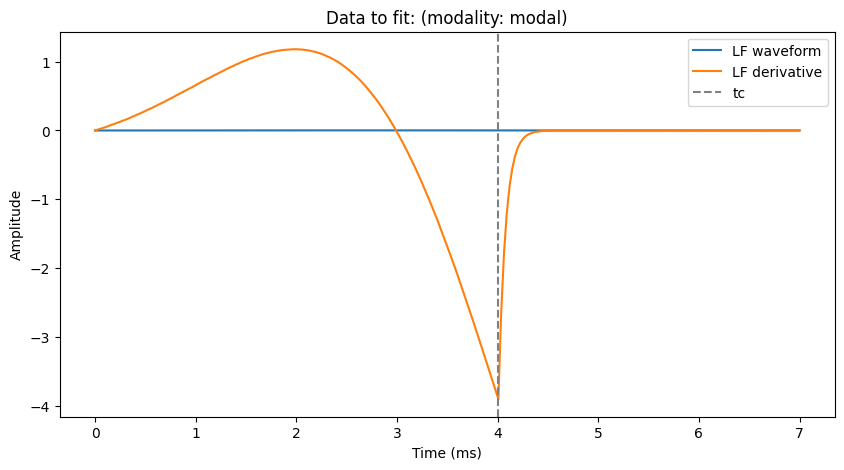

In [7]:
from gfm.lf import lf_modality_waveforms

period = 7.0  # msec
N = 256

lfs = lf_modality_waveforms(
    period_ms=period, samples_per_period=N, normalize_power=True, add_noise=True
)
d = lfs[modality]

t, du, u = d["t"], d["du"], d["u"]
tc = d["timings"]["Te"] * 1000

fig, ax = plt.subplots(figsize=(10, 5))
plt.title(f"Data to fit: (modality: {modality})")
plt.plot(t, u, label="LF waveform")
plt.plot(t, du, label="LF derivative")
plt.axvline(tc, color="gray", linestyle="--", label="tc")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()

In [ ]:
# build generative model
from scipy.special import ndtri
from tinygp.gp import GaussianProcess
from gfm.kernel import build_theta

hyper = {
    "T": period,
    "normalized": normalized,
    "centered": centered,
}


def build_theta_hack(x, kernel):
    if not hyper["centered"]:
        theta = build_theta(x, kernel)
    else:
        theta = build_theta(x[:-1], kernel)
        theta["center"] = x[-1]
    return theta


def build_gp(theta):
    hyper["center"] = theta.get("center", None)
    k = instantiate_kernel(kernel, theta, hyper)
    gp = GaussianProcess(kernel=k, X=t, diag=theta["sigma_noise"] ** 2)
    return gp


@jax.jit
def loglikelihood(x):
    theta = build_theta_hack(x, kernel)
    gp = build_gp(theta)
    return gp.log_probability(du)


def ptform(u):
    if not hyper["centered"]:
        z = ndtri(u)
        x = 10.0**z
    else:
        z = ndtri(u[:-1])
        center = period * u[-1]  # uniform in [0, tc]
        x = np.concatenate([10.0**z, np.array([center])])
    return x


In [ ]:
# smoke test
rng = np.random.default_rng(seed)

x = ptform(rng.uniform(size=100))
theta = build_theta_hack(x, kernel)
ndim = len(theta)

theta_noiseless = theta.copy()
theta_noiseless["sigma_noise"] = 1e-6

s = build_gp(theta_noiseless).sample(jax.random.PRNGKey(seed), shape=(3,))

plt.title(f"kernel: {kernel}, centered: {centered}, normalized: {normalized}")
plt.plot(t, s.T, label="sample from GP prior")
plt.legend()

loglikelihood(x)

In [ ]:
# initialize our nested sampler
nlive = 256

sampler = NestedSampler(
    loglikelihood, ptform, ndim, nlive=nlive, rstate=rng, sample="rwalk"
)

with time_this() as elapsed:
    sampler.run_nested(maxcall=2_000_000, print_progress=False)


In [ ]:
res = sampler.results

res.summary()


In [ ]:
xs = res.samples_equal()[:100]

means = {}
stds = {}

for x in xs:
    theta = build_theta_hack(x, kernel)
    for k, v in theta.items():
        if "sigma" in k or "ell" in k:
            v = np.log10(v)
            k = f"{k}_log10"
        means[k] = means.get(k, 0.0) + v
        stds[k] = stds.get(k, 0.0) + v * v

N = float(len(xs))

means = {k: v / N for k, v in means.items()}
stds = {k: np.sqrt(stds[k] / N - means[k] * means[k]) for k in means}

print(means)
print(stds)

for x in xs[:5]:
    theta = build_theta_hack(x, kernel)

    print(theta)

    gp = build_gp(theta)
    mu, var = gp.predict(du, t, return_var=True)
    std = jnp.sqrt(var) + theta["sigma_noise"]

    plt.fill_between(
        t,
        mu - 1.96 * std,
        mu + 1.96 * std,
        alpha=0.2,
    )
    plt.plot(t, mu, label="GP posterior mean")

plt.plot(t, du, label="data")

plt.title(f"kernel: {kernel}, centered: {centered}, normalized: {normalized}")
plt.legend()

In [ ]:
from dynesty import plotting as dyplot

try:
    fig, ax = dyplot.cornerplot(
        res,
        labels=[str(k) for k in theta.keys()],
        verbose=True,
        quantiles=[0.05, 0.5, 0.95],
    )
except Exception as e:
    print(f"Could not make corner plot: {e}")


In [ ]:
# export
te = t[np.argmin(du)]
mean = means
std = stds

In [ ]:
# export
logz = res.logz[-1]
logzerr = res.logzerr[-1]

ndim = res.samples.shape[1]
information = res.information[-1]

niter = res.niter
ncall = res.ncall.sum()
walltime = elapsed.walltime